In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import os
import ast
from shapely import wkt

from his_geo import extractor
from his_geo import geocoder

import geopy
from geopy.distance import geodesic
import shapely.geometry
from shapely.geometry import MultiPolygon, Polygon
from itertools import combinations

import matplotlib.pyplot as plt


# Set prompt and other parameters

In [46]:
prompt = """
I would like you to take on the roles of both a Geographer and a Historian. 
You possess extensive knowledge in Chinese geography and history, with a particular expertise in historical toponymy. 
Your task is to extract precise location references of historical toponyms from texts.
When I provide a scholarly text analyzing the location of one or several historical toponyms, please identify and extract both the toponyms and their corresponding location references from the text. 
Keep the following in mind:
1. If the text presents differing opinions of the same historical toponym's location from various scholars, only extract the most correct location reference that the author of the text acknowledges or agrees with. Do not include location references that the author disputes.
2. If a toponym is mentioned in the text but no location is provided, please skip this toponym.
3. Present the extracted information always in Chinese and strictly adhere to the following format:
   "Toponym 1", "Location 1"
   "Toponym 2", "Location 2"
   Please do not include any explanation, verb or extraneous information.

The text is as follows:

         """

In [47]:
api_key = "Your API key"

In [48]:
models = ["chatgpt"]
chatgpt_model_versions = ["gpt-3.5-turbo-1106", "gpt-4-1106-preview"]

# Load data

In [49]:
df = pd.read_csv('./evaluation/input.csv')
texts = df['text'].tolist()

# Create extractor and run

In [50]:
llm_extractor = extractor.Extractor(prompt, output_dir="./evaluation/", 
                                    model="chatgpt", model_version="gpt-3.5-turbo-1106", api_key=api_key)

In [51]:
results = llm_extractor.extract_texts(texts)

Extracting text 0 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-1106.json
Extracting text 1 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-1106.json
Extracting text 2 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-1106.json
Extracting text 3 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-1106.json
Extracting text 4 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-1106.json
Extracting text 5 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-1106.json
Extracting text 6 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-1106.json
Extracting text 7 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-1106.json
Extracting text 8 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-1106.json
Extracting text 9 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-1106.json
Extracting text 10 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-1106.json
Extracting text 11 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-

In [52]:
llm_extractor = extractor.Extractor(prompt, output_dir="./evaluation/", 
                                    model="chatgpt", model_version="gpt-4-1106-preview", api_key=api_key)

In [53]:
results = llm_extractor.extract_texts(texts)

Extracting text 0 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json
Extracting text 1 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json
Extracting text 2 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json
Extracting text 3 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json
Extracting text 4 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json
Extracting text 5 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json
Extracting text 6 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json
Extracting text 7 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json
Extracting text 8 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json
Extracting text 9 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json
Extracting text 10 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json
Extracting text 11 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-pre

# Post-processing

In [40]:
def json_to_dataframe(json_file):
    with open(json_file, 'r', encoding="utf-8-sig") as f:
        data = json.load(f)
    df = pd.DataFrame(columns=['id', 'toponym', 'location'])
    for key, value in data.items():
        result = value.split('\n')
        for item in result:
            if item != '':
                try:
                    row = {'id': key, 'toponym': item.split(',')[0].strip(), 'location': item.split(',')[1].strip()}
                except:
                    row = {'id': key, 'toponym': item, 'location': ''}
                df.loc[len(df)] = row
    return df


def match_ids(df_result, df_original):
    df_ids = df_original[['id']].copy()

    df_result.set_index('id', inplace=True)
    df_result.index.name = None
    df_ids.index = df_ids.index.astype('int64')
    df_result.index = df_result.index.astype('int64')

    df_result = df_result.merge(df_ids, left_index=True, right_index=True, how='left')
    df_result = df_result[['id', 'toponym', 'location']]
    return df_result

In [42]:
# structuralize the results
df_original = pd.read_csv('./evaluation/input.csv')

json_dir = './evaluation/'
json_files = [i for i in os.listdir(json_dir) if i.endswith('.json')]

for json_file in json_files:
    df_result = json_to_dataframe(json_dir + json_file)
    df_result = match_ids(df_result, df_original)
    df_result.dropna(subset=['location'], inplace=True)
    df_result = df_result[~df_result['location'].str.contains('不详')]
    df_result = df_result[~df_result['location'].str.contains('未明确')]
    df_result = df_result[~df_result['location'].str.contains('未提供')]
    df_result = df_result[~df_result['location'].str.contains('不明确')]
    df_result = df_result[~df_result['location'].str.contains('不提供')]
    df_result = df_result[~df_result['location'].str.contains('未提及')]
    df_result = df_result[~df_result['location'].str.contains('未详')]
    df_result = df_result[~df_result['location'].str.contains('无法确定')]
    df_result = df_result[~df_result['location'].str.contains('[A-Za-z]')]
    df_result.to_csv(json_dir + json_file[:-5] + '.csv', index=False, encoding='utf-8-sig')

# Geocoding

In [3]:
files_dir = './evaluation/'
files = [i for i in os.listdir(files_dir) if "extracted_results" in i and i.endswith('.csv')]
for file in files:
    df = pd.read_csv(files_dir + file, encoding='utf-8-sig')
    addresses = df['location'].tolist()
    geocoder_evaluate = geocoder.Geocoder(addresses, 
                                          lang="ch", 
                                          preferences=['modern', 'historic'], 
                                          geographic_crs="EPSG:4326", 
                                          if_certainty=True)
    geocoder_evaluate.detect_direction()
    geocoder_evaluate.match_address()
    geocoder_evaluate.calculate_point()
    df_geocoded = geocoder_evaluate.data.reset_index().copy()
    df = df.reset_index().copy()
    df = df.merge(df_geocoded, left_index=True, right_index=True, how='left')
    df.to_csv(files_dir + file[:-4] + '_geocoded.csv', index=False, encoding='utf-8-sig')

Initialization finished.
Detection finished.
['今湖北省荆门县']
[['湖北', '荆门']] [{'prefecture': 4208}] Prefecture [] modern
['今湖北省荆门县']
[['湖北', '荆门']] [{'prefecture': 4208}] Prefecture [] modern
['今河南省唐河县']
[['河南', '唐河']] [{'county': 411328}] County [] modern
['今河南省固始县']
[['河南', '固始']] [{'county': 411525}] County [] modern
['湖北省襄樊市']
[['湖北', '']] [{'county': 420102}] County [] modern
['河南省邓州市']
[['河南', '邓州']] [{'county': 411381}] County [] modern
['今河南省南阳市']
[['河南', '南阳']] [{'prefecture': 4113}] Prefecture [] modern
['今河南省南阳市']
[['河南', '南阳']] [{'prefecture': 4113}] Prefecture [] modern
['河南省南阳市']
[['河南', '南阳']] [{'prefecture': 4113}] Prefecture [] modern
['楚县']
[['']] [{'county': 150102}] County [] modern
['今河南省息县']
[['河南', '息']] [{'county': 411528}] County [] modern
['今陕西省商县东南之商洛县']
[['陕西', '商洛', '商']] [{'county': 611002}] County [] modern
['今河南省淅川县']
[['河南', '淅川']] [{'county': 411326}] County [] modern
['今河南省淮滨县东南期思乡']
[['河南', '淮滨']] [{'county': 411527}] County [] modern
['河南省西峡县']
[['河南', '

c:\ProgramData\Anaconda3\envs\NLP\lib\site-packages\shapely\set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


['今湖北省荆门市']
[['湖北', '荆门']] [{'prefecture': 4208}] Prefecture [] modern
['今湖北省荆门市东南流权城']
[['湖北', '荆门']] [{'prefecture': 4208}] Prefecture [] modern
['河南省唐河县']
[['河南', '唐河']] [{'county': 411328}] County [] modern
['河南省固始县']
[['河南', '固始']] [{'county': 411525}] County [] modern
['湖北省襄樊市']
[['湖北', '']] [{'county': 420102}] County [] modern
['今河南省南阳市']
[['河南', '南阳']] [{'prefecture': 4113}] Prefecture [] modern
['河南省南阳市']
[['河南', '南阳']] [{'prefecture': 4113}] Prefecture [] modern
['河南省南阳市']
[['河南', '南阳']] [{'prefecture': 4113}] Prefecture [] modern
['今河南省息县']
[['河南', '息']] [{'county': 411528}] County [] modern
['今湖北省均县附近']
[['湖北', '均']] [{'county': 420381}] County [] modern
['河南省淮滨县东南期思乡']
[['河南', '淮滨']] [{'county': 411527}] County [] modern
['河南省固始县东北、史灌河以东近淮河南岸']
[['河南', '固始']] [{'county': 411525}] County [] modern
['今河南省西峡县']
[['河南', '西峡']] [{'county': 411323}] County [] modern
['析']
[['']] [{'county': 150102}] County [] modern
['湖北省襄阳市']
[['湖北', '襄阳']] [{'prefecture': 4206}] Prefecture []

c:\ProgramData\Anaconda3\envs\NLP\lib\site-packages\shapely\set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
c:\ProgramData\Anaconda3\envs\NLP\lib\site-packages\shapely\set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


# Evaluate

$$ 
closeness(p_i, p_j) = \begin{cases} \frac{\cos{(\frac{\pi}{n} \cdot distance(p_i, p_j)) + 1 }}{2} &, \ if \ 0 \le x \le n \\0 &, \ if \ x \gt n \end{cases} 
$$

While p_i and p_j represent the point of the extracted location and the ground truth location, respectively, the distance is the geodesic distance (km) between two points, and n is a predetermined baseline distance (km) that acts as a threshold.

The closeness ranges from 0 to 1. When the distance is zero, the function yields a closeness value of 1. When the distance is between 0 and the baseline distance n, the closeness follows a non-linear cosine decay pattern, characterized by a gradual decrease, followed by a rapid decline, and finally a slow decrease to 0. As the distance exceeds the baseline distance n, the closeness value becomes zero.

We determined the baseline distance n to be the maximum geodesic distance between any two points within the polygon of the highest accuracy level matched with the groundtruth location.


$$
\text{Precision} = \frac{1}{T} \sum_{i=1}^{T} \left( \frac{1}{E_i} \sum_{j=1}^{E_i} C_{ij} \right)
$$


The Precision is calculated as the average of the average closeness scores for locations extracted from each text in the dataset. 
Here, $T$ represents the total number of texts in the dataset. 
For each text, denoted as i, there is a set of locations extracted from it, and $E_i$ is the number of locations extracted from text i.
$C_{ij}$ represents the closeness score of location j in text i. 

$$
\text{Recall} = \frac{1}{T} \sum_{i=1}^{T} \left( \frac{1}{G_i} \sum_{j=1}^{G_i} \left( \frac{1}{E_{ij}} \sum_{k=1}^{E_{ij}} C_{ijk} \right) \right)
$$

The Recall is calculated as the average of the average of the average closeness scores for extracted locations matched with each ground truth location from each text in the dataset. 
Here, $T$ represents the total number of texts in the dataset. 
For each text, denoted as i, there is a set of ground truth locations, and $G_i$ is the number of ground truth locations in text i. 
For each ground truth location, denoted as j, there is one or a set of locations extracted by the model, and $E_{ij}$ represents the number of extracted locations matched with ground truth location ij.
$C_{ijk}$ represents the closeness score of extracted location k matched with ground truth location j in text i.


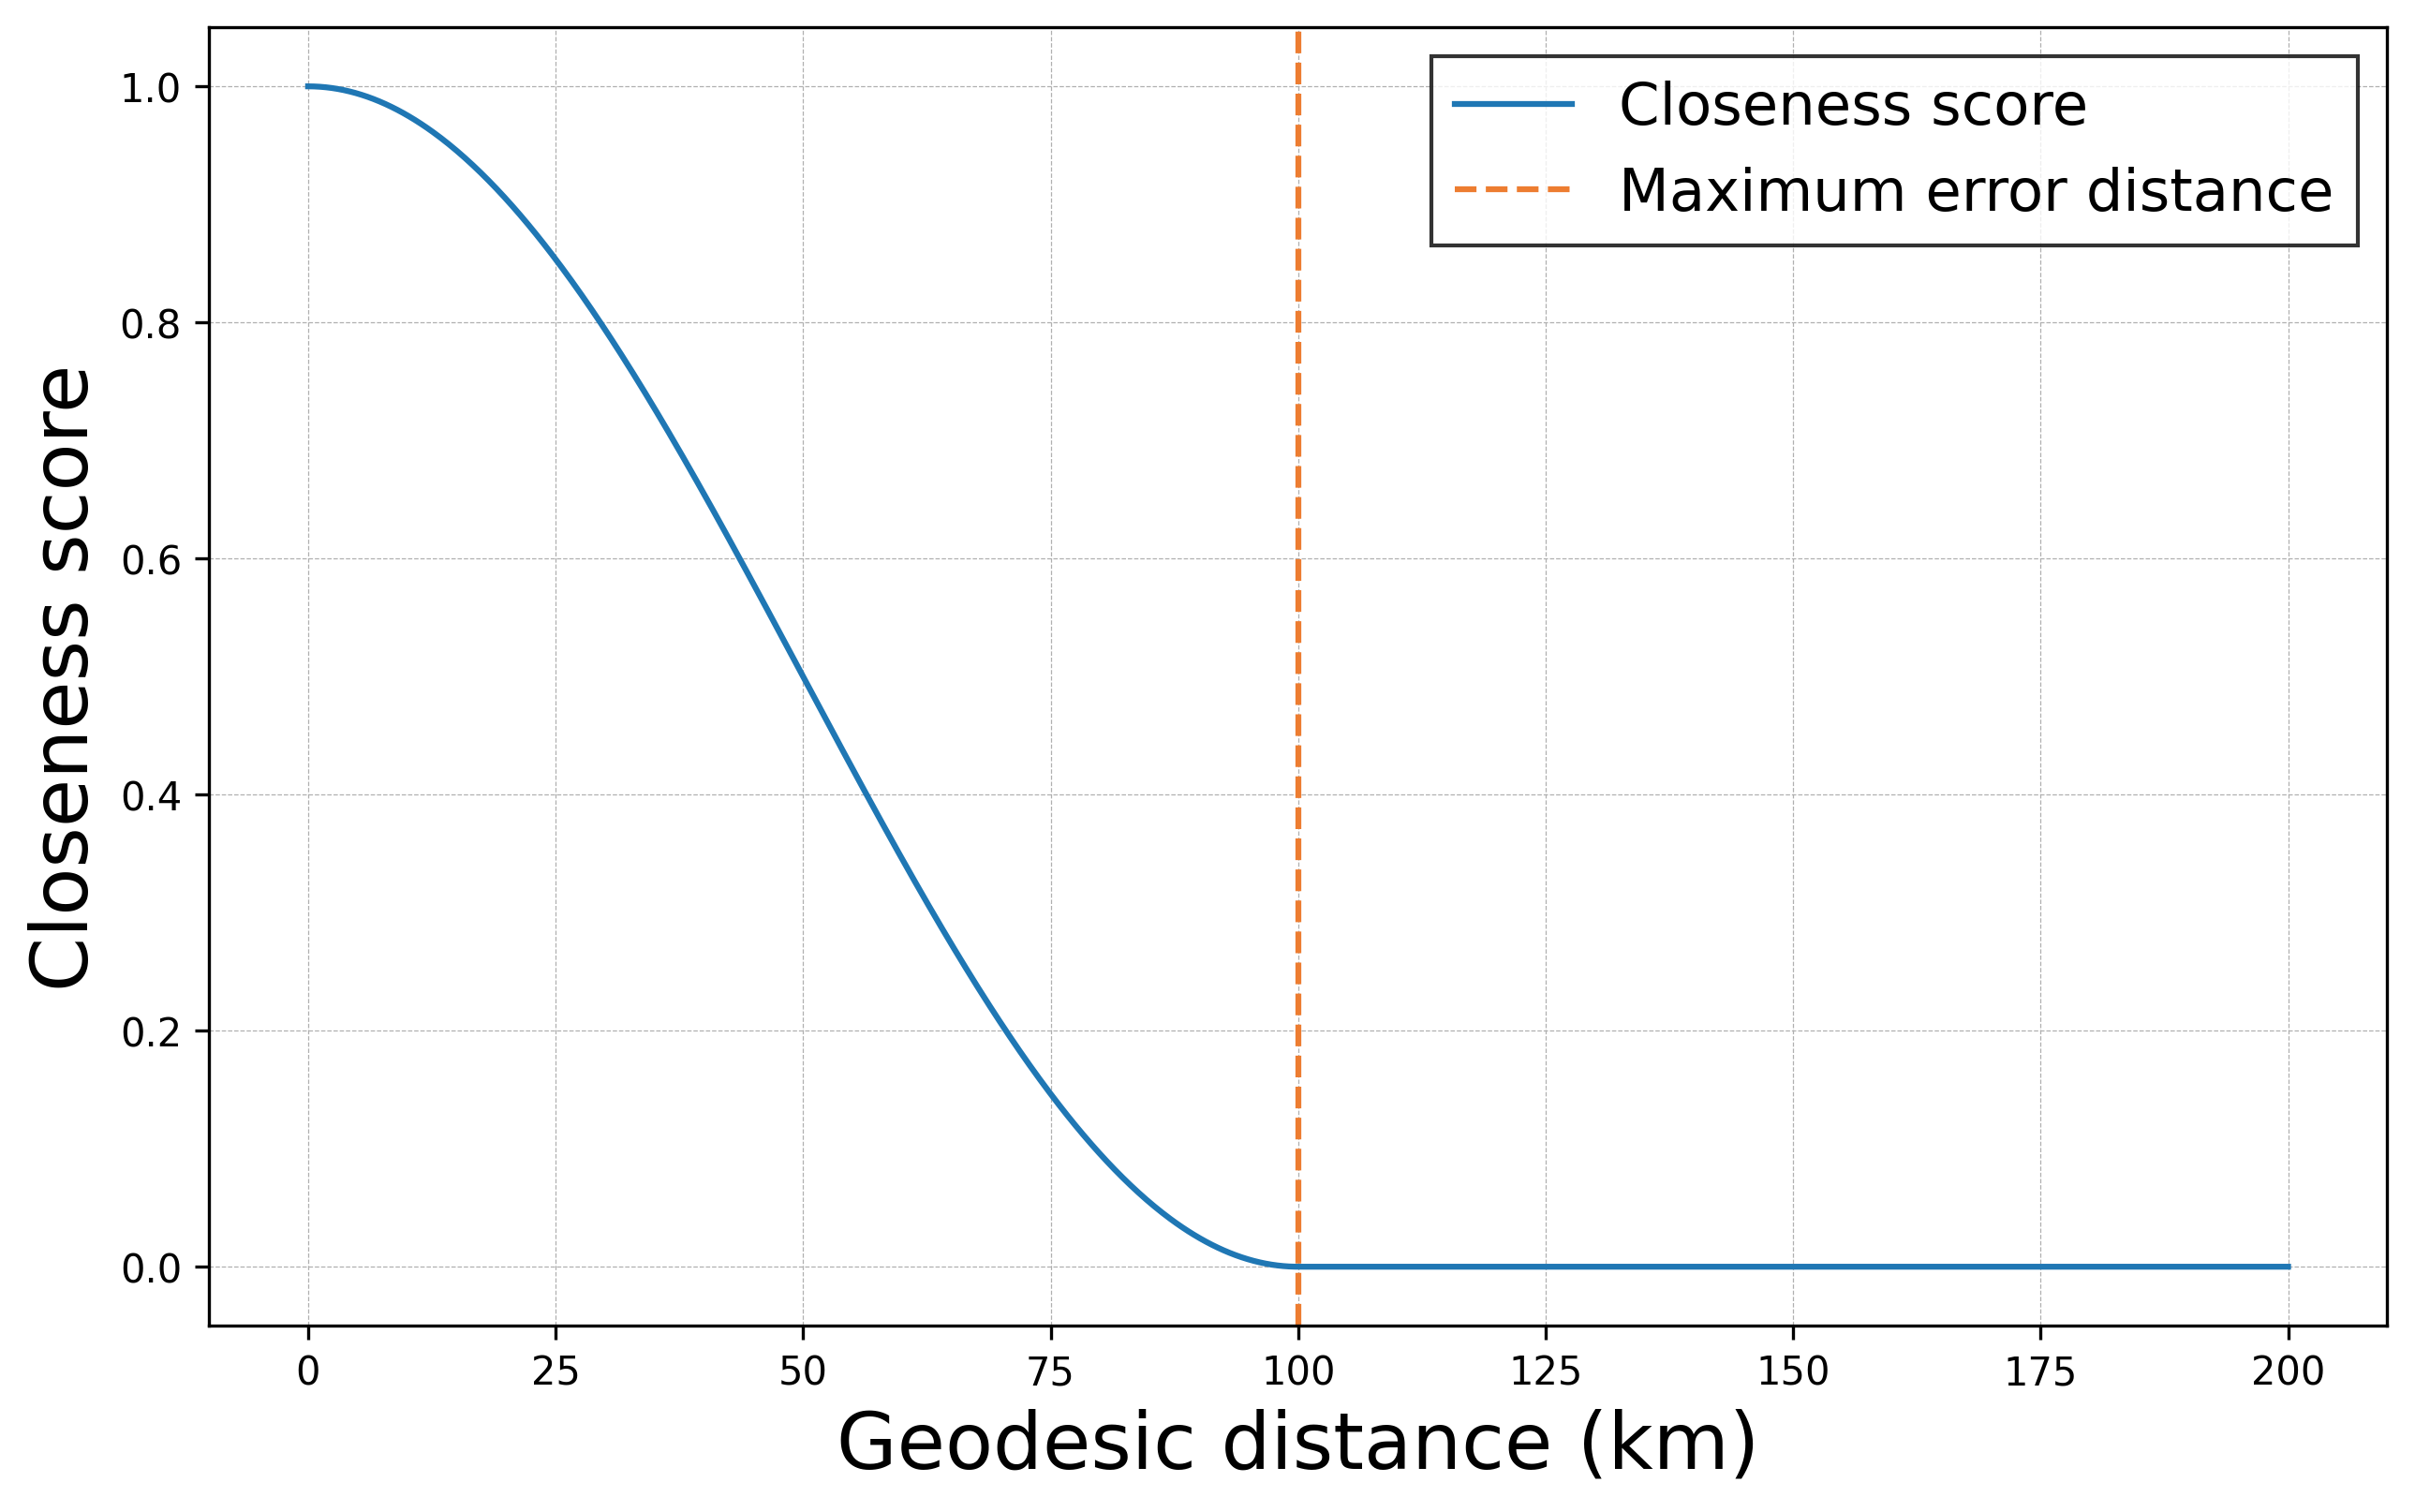

In [2]:
def closeness(x, n):
    """
    Calculate the closeness of the extracted result to the benchmark result
    :param x (km): geodesic distance between the extracted point and the benchmark point
    :param n (km): baseline distance (max geodesic distance inside the most accurate level polygon of the benchmark data)
    """
    if x <= n:
        return (np.cos(x*(np.pi/n))+1)/2
    else:
        return 0

n = 100  # Baseline distance decided by the max length of the most accurate level polygon of the benchmark data
x_values = np.linspace(0, 2*n, 1000)  # x from 0 to 2 times the baseline distance


# Calculate closeness values
closeness_values = [closeness(x, n) for x in x_values]

# Plotting
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(x_values, closeness_values)
# plot a vertical line
plt.axvline(x=n, color='#ED7D31', linestyle='--')
# add annotation and use it in legend
plt.legend(['Closeness score', 'Maximum error distance'], fancybox=False, loc='upper right', fontsize=15, edgecolor='black')

plt.xlabel('Geodesic distance (km)', fontsize=20)
plt.ylabel('Closeness score', fontsize=20)
plt.grid(True, linestyle='--', linewidth=0.3)
plt.savefig('./figures/closeness.png', dpi=300)
plt.show()


In [3]:
def shapely_point_to_geopy(point_shapely):
    return (point_shapely.y, point_shapely.x)


def calculate_geo_closeness(point1, point2, maximum_error_distance):
    # Geodesic Distance between two points
    point1, point2 = shapely_point_to_geopy(point1), shapely_point_to_geopy(point2)
    distance =  geodesic(point1, point2).kilometers
    # Maximum error distance as cut-off
    n = maximum_error_distance
    # Closeness
    closeness_value = closeness(distance, n)
    return closeness_value


def calculate_geo_closeness_for_all_text(gdf_result, gdf_benchmark):
    # # Check if the number of unique ids in the result is the same as the benchmark
    # if len(gdf_result['id'].unique()) != len(gdf_benchmark['id'].unique()):
    #     print("Number of unique ids in the result is not the same as the benchmark")
    # else:
    gdf_result['closeness'] = 0
    gdf_result['target_toponym'] = None
    # Iterate through each text (section)
    for id in gdf_benchmark['id'].unique():
        gdf_section_benchmark = gdf_benchmark[gdf_benchmark['id'] == id]
        gdf_section_result = gdf_result[gdf_result['id'] == id]

        # Iterate through each extracted toponym
        for index_result, row_result in gdf_section_result.iterrows():
            if len(gdf_section_result) == 0:
                pass
            else:
                result_toponym = row_result['toponym'].replace("县", "").replace("国", "")
                for index_benchmark, row_benchmark in gdf_section_benchmark.iterrows():
                    benchmark_toponym = row_benchmark['toponym'].replace("县", "").replace("国", "")
                    print(id, result_toponym, benchmark_toponym)
                    if benchmark_toponym in result_toponym or result_toponym in benchmark_toponym:
                        gdf_result.loc[index_result, 'target_toponym'] = benchmark_toponym
                        if row_result['geometry'] is None or row_result['geometry'].is_empty:
                            closeness_value = 0
                        else:
                            if row_benchmark['geometry'] is None or row_benchmark['geometry'].is_empty:
                                # Change in the future
                                closeness_value = 0
                            else:
                                # Get the most accurate level polygon of the benchmark data
                                closeness_value = calculate_geo_closeness(row_result['geometry'], row_benchmark['geometry'], row_benchmark['Maximum Error Distance'])
                                print(row_result['Address'], row_benchmark['Address'], row_benchmark['Maximum Error Distance'])
                                break
                    else:
                        closeness_value = 0
                # Add the closeness score to the result dataframe
                print(closeness_value)
                gdf_result.loc[index_result, 'closeness'] = closeness_value

    return gdf_result


def calculate_precision(gdf_result):
    section_precisions = gdf_result.groupby('id')['closeness'].mean()
    total_precision = section_precisions.mean()
    return total_precision


def calculate_scores(gdf_result, gdf_benchmark):

    total_precision = 0
    total_recall = 0
    total_f1 = 0

    for id in gdf_result['id'].unique():
        gdf_section_benchmark = gdf_benchmark[gdf_benchmark['id'] == id]
        gdf_section_result = gdf_result[gdf_result['id'] == id]

        # calculate precision for each section (text)
        section_precision = gdf_section_result['closeness'].mean()
        total_precision += section_precision

        # calculate recall for each section (text)
        section_recall = 0
        for i in range(len(gdf_section_benchmark)):
            benchmark_toponym = gdf_section_benchmark.iloc[i]['toponym'].replace("县", "").replace("国", "")
            if benchmark_toponym not in gdf_section_result['target_toponym'].tolist():
                section_recall += 0
            else:
                section_recall += gdf_section_result[gdf_section_result['target_toponym'] == benchmark_toponym]['closeness'].max()
        section_recall = section_recall / len(gdf_section_benchmark)
        total_recall += section_recall

        # calculate f1 score for each section (text)
        if section_precision == 0 and section_recall == 0:
            section_f1 = 0
        else:
            section_f1 = 2 * section_precision * section_recall / (section_precision + section_recall)
        total_f1 += section_f1

    total_precision = total_precision / len(gdf_result['id'].unique())
    total_recall = total_recall / len(gdf_result['id'].unique())
    total_f1 = total_f1 / len(gdf_result['id'].unique())
   

    return total_precision, total_recall, total_f1

In [4]:
df_benchmark = pd.read_csv('./evaluation/benchmark.csv', encoding='utf-8-sig')
gdf_benchmark = gpd.GeoDataFrame(df_benchmark, geometry=gpd.points_from_xy(df_benchmark.X, df_benchmark.Y))

In [5]:
file_dir = './evaluation/'
files = [i for i in os.listdir(file_dir) if 'geocoded' in i and i.endswith('.csv')]

for file in files:
    df_result = pd.read_csv(file_dir + file, encoding='utf-8-sig')
    df_result['geometry'] = df_result['geometry'].apply(wkt.loads)
    gdf_result = gpd.GeoDataFrame(df_result, geometry='geometry')
    gdf_result = calculate_geo_closeness_for_all_text(gdf_result, gdf_benchmark)
    print(gdf_result)
    gdf_result.to_csv(file_dir + file[:-4] + '_evaluated.csv', encoding='utf-8-sig')

1.0 权 ﻿权
['今湖北省荆门县东南'] ['湖北省荆门县东南'] 155.8392281
1.0
1.0 权 ﻿权
['今湖北省荆门县东南'] ['湖北省荆门县东南'] 155.8392281
1.0
3.0 廖 湖阳
0
3.0 蓼 湖阳
0
4.0 邓 邓
['湖北省襄樊市'] ['湖北省襄樊市西北'] 17.17430851
0.8843722622293666
4.0 邓 邓
['河南省邓州市'] ['湖北省襄樊市西北'] 17.17430851
0
5.0 申 ﻿申
['今河南省南阳市'] ['河南省南阳县'] 281.5621608
1.0
5.0 宛城 ﻿申
0
6.0 吕 吕
['河南省南阳市西'] ['今河南省南阳市西'] 281.5621608
1.0
6.0 申 吕
0
7.0 息 ﻿息
['今河南省息县西南'] ['河南省息县西南'] 63.4238693
1.0
8.0 商 商
['今陕西省商县东南之商洛县'] ['今湖北省均县附近'] 82.15262921
0
8.0 商密 商
['今河南省淅川县西南'] ['今湖北省均县附近'] 82.15262921
0.6202869295400371
9.0 期思 ﻿期思
['今河南省淮滨县东南期思乡'] ['河南省淮滨县东南期思乡'] 55.69217628
1.0
10.0 析 ﻿析
['河南省西峡县'] ['河南省西峡县'] 87.43215002
1.0
10.0 白羽 ﻿析
0
10.0 容城 ﻿析
0
12.0 庐 ﻿庐
['湖北省襄樊市西南'] ['今湖北省襄樊市西南'] 17.17430851
1.0
12.0 庐戢桨 ﻿庐
0
11.0 鄀 鄀
['河南省淅川县西南'] ['河南省淅川县西南'] 105.8536459
1.0
11.0 商密 鄀
0
11.0 宜城 鄀
0
11.0 郢 鄀
0
11.0 番 鄀
0
11.0 鄢 鄀
0
13.0 庸 ﻿庸
['湖北省竹山县西南'] ['湖北省竹山县西南'] 125.8539942
1.0
14.0 宛丘 陈
0
15.0 沈尹 ﻿沈
0
15.0 沈尹寿 ﻿沈
0
15.0 沈尹射 ﻿沈
0
15.0 沈尹赤 ﻿沈
0
15.0 沈尹戌 ﻿沈
0
15.0 沈尹朱 ﻿沈
0
16.0 城父 ﻿城父
['今河南省襄城县西

In [8]:
file_dir = './evaluation/'
files = [i for i in os.listdir(file_dir) if 'evaluated' in i]
for file in files:
    df = pd.read_csv(file_dir + file, encoding='utf-8-sig')

    # remove results with no locations
    df.dropna(subset=['location'], inplace=True)
    df = df[~df['location'].str.contains('不详')]
    df = df[~df['location'].str.contains('未明确')]
    df = df[~df['location'].str.contains('未提供')]
    df = df[~df['location'].str.contains('不提供')]
    df = df[~df['location'].str.contains('不明确')]
    df = df[~df['location'].str.contains('未提及')]
    df = df[~df['location'].str.contains('无法确定')]
    df = df[~df['location'].str.contains('未详')]
    df = df[~df['location'].str.contains('[A-Za-z]')]

    precision, recall, f1 = calculate_scores(df, gdf_benchmark)
    print(file)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1:', f1)

extracted_results_chatgpt_gpt-3.5-turbo-1106_geocoded_evaluated.csv
Precision: 0.6722099644149508
Recall: 0.8207012542329094
F1: 0.7124122931627168
extracted_results_chatgpt_gpt-4-1106-preview_geocoded_evaluated.csv
Precision: 0.7234598357935599
Recall: 0.8259480922892433
F1: 0.7538065333635189
